# Classification of Anomalous Diffusion

We'll develop a recurrent neural network to classify different kinds of motions obeying different anomalous diffusion models.

## Load Anomalous Diffusion Models

We load the `datasets_theory()` class from the `andi_datasets` package.

In [1]:
from andi_datasets.datasets_theory import datasets_theory

AnDi = datasets_theory()
model_names = AnDi.avail_models_name
model_number = len(model_names)

print(f"{model_number} nomalous diffusion models: {model_names}")


5 nomalous diffusion models: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']


## Simulate Trajectories

We now proceed to simulate the necessary trajectories for the dataset. This might take a few minutes. This will generate `N = 4000` trajectories for each anomalous diffusion model, each with random anomalous diffusion coefficients. Each trajectory contains `T = 100` time steps.

The dataset contains rows with lenght `2 + D * T`, with the following structure:
* First column: model label 
* Second column: value of the anomalous exponent
* Following columns: trajectories

In [2]:
from numpy import concatenate as cat
from numpy.random import rand

T = 100  # Time steps.
N = 4000  # Trajectories per model.
D = 2  # Dimensionality.

dataset = cat((
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=(rand(N) + 0.2) / 1.2,
        models=[0, 1],  # attm, ctrw
        dimension=D, 
    ),
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=(rand(N) * 1.8) + 0.2,
        models=[2, 4],  # fbm, sbm
        dimension=D, 
    ),
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=rand(N) + 1,
        models=3,  # lw
        dimension=D, 
    ),
), axis=0)

print(f"{dataset.shape}")

(20000, 202)


## adding localization noise

We now shuffle the dataset and extract the model numbers, anomalous exponents, and the x and y components of the trajectories.

In [3]:
from numpy.random import shuffle

shuffle(dataset)

models = dataset[:, 0]
exponents = dataset[:, 1]
trajectories = dataset[:, 2:].reshape(-1, T, D, order='F')


We also standardize the trajectories.

In [11]:
trajectories -= trajectories.mean(axis=1, keepdims=True)
trajectories /= trajectories.std(axis=1, keepdims=True)  # CARLO: there are some trajectories whsoe std are nan, can you check why?

## Visualize Trajectories

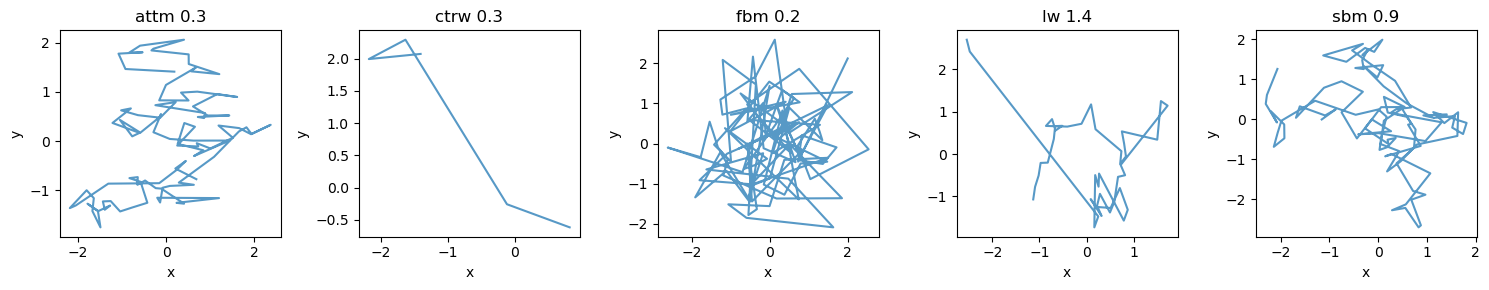

In [10]:
import matplotlib.pyplot as plt
from numpy import where

fig, axs = plt.subplots(1, model_number, figsize=((15, 3)), tight_layout=True)

for m, ax in zip(range(model_number), axs):
    idx = where(models == m)[0][0]
    ax.plot(trajectories[idx, :, 0], trajectories[idx, :, 1], alpha = 0.75)
    ax.set_title(f"{model_names[m]} {exponents[idx]:.1f}")
    plt.setp(ax, xlabel="x", ylabel="y")

## Prepare Data

We now prepare the data to be used by for the neural network training. We start by reshaping the trajectories according to a tme `window` to be used in the recurrent neural network training.

In [24]:
window = 2
n_timesteps = int(T / window)
n_features= D * window

inputs = trajectories.reshape(trajectories.shape[0], n_timesteps, n_features)

We then one-hot encode the targets. For this, we first implement two functions, that we add to `fnc_andi.py` ...

```python
```

```python
```

... and then use them to one-hot encode the anomalous diffusion models.

In [16]:
from numpy import argmax, zeros

def digits_to_one_hot(digits, n_classes):
    """Convert an array of integer digits to a 2D one-hot encoded matrix."""
    
    one_hot_labels = zeros((digits.shape[0], n_classes))
    for idx, digit in enumerate(digits): 
        one_hot_labels[idx, digit] = 1
    return one_hot_labels
    
def one_hot_to_digit(one_hot_labels):
    """Convert a 2D one-hot encoded matrix to a 1D array of integer digits."""
    
    return argmax(one_hot_labels , axis=-1)


In [20]:
#from fnc_andi import digits_to_one_hot

targets = digits_to_one_hot(models.astype(int), model_number)

We then convert them into PyTorch tensors ...

In [21]:
import torch

inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

... split them into train, validation, and test datasets ...

In [22]:
from torch.utils.data import random_split, TensorDataset

[train_ds, val_ds, test_ds] = random_split(TensorDataset(inputs, targets), 
                                           [0.6, 0.2, 0.2])

... and create the necessary data loaders.

In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

## Use Simple RNN

We start by using a simple RNN.

In [26]:
import deeplay as dl

rnn = dl.RNN(
    n_features, 
    hidden_features=[100],
    out_features=model_number,
    dropout=0.2,
    rnn_type="RNN", 
)
model_rnn = dl.Classifier(
    rnn, 
    loss=torch.nn.CrossEntropyLoss(), 
    optimizer=dl.Adam(lr=0.001)
).create()

print(model_rnn)  # HENRIK, BENJAMIN: There seems to be a problem in the implementaiton of dropout (see printout)

Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(4, 100, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=100, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormal

We now proceed to train the neural network ...

In [27]:
trainer_rnn = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_rnn.fit(model_rnn, train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-12-24 08:31:48.050160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 11.1 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.044     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


... and test it on the test dataset ...

In [28]:
preds_rnn = trainer_rnn.predict(model_rnn, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

... and evaluate its performance. For this, we write the `accuracy()` function, save it into `fnc_andi.py` ...

```python
```

... and use it to calculate the accuracy.

In [ ]:
from seaborn import heatmap , cubehelix_palette
from numpy import zeros

def confusion_matrix(predicted_y,y_test):
    # Compute the confusion matrix
    confusion_matrix = zeros((5, 5))
    predicted = one_hot_to_digit(predicted_y)
    groundtruth = one_hot_to_digit(y_test)
    for groundtruth_m , predicted_m in zip(groundtruth , predicted):
        confusion_matrix[ predicted_m, groundtruth_m ] += 1
    confusion_matrix=100.*confusion_matrix/confusion_matrix.sum(axis=0,keepdims=1)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8)) 
    heatmap(confusion_matrix, annot=True, fmt=".1f", square=True, cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax =100)
    plt.ylabel("Predicted model", fontsize=15)
    plt.xlabel("Ground truth model", fontsize=15) 
    locs, NA = plt.xticks() 
    plt.xticks(ticks=locs, labels=model_names)
    locs, NA = plt.yticks() 
    plt.yticks(ticks=locs, labels=model_names)

    plt.show()

confusion_matrix(predicted_y,y_test)

## GRU

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.GRU)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## LSTM

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.LSTM)
rnn.blocks[0].layer.configure(hidden_size=50) #to bring the total parameter count more in-line with a simple RNN
rnn.blocks[1].layer.configure(in_features=50)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Bidirectional LSTM

In [ ]:
rnn = dl.RNN(n_features,hidden_features=[50],out_features=n_outputs,dropout=0.2,rnn_type="LSTM",bidirectional=True)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Adding layers to LSTM (overfitting)

In [ ]:
rnn = dl.RecurrentNeuralNetwork(n_features,hidden_features=[100],out_features=30)
rnn.blocks.layer.configure(torch.nn.LSTM)
rnn.blocks.dropout.configure(p=0.2)

dense_top=dl.MultiLayerPerceptron(in_features=None,hidden_features=[15],out_features=n_outputs)
dense_top.blocks.dropout.configure(p=0.2)

dense_rnn = dl.Sequential(rnn,dense_top)
model = dl.Classifier(dense_rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)